# Biotype exploration

compare the top gene transcript between day 5, control, 'exo vs bulk' bio types

## load  transcipt level count and bio type data
read data files created by extraCellularRNA/R/notebooks/kras.ipsc_exo_vs_bulk.DESeq.Rmd

the original data came was produced Using Salmon. 

## TODO
- salmon quant.sf files have biotype information. Should we use the count values in quant.sf files or use the 'normalized counts' from tximport/DESeq? They are normalized for library size

In [1]:
from   bme263DataVis.utilities import MatPlotLibUtilities
from   bme263DataVis.plotProbMassFunc import PlotProbMass

# https://songhuiming.github.io/pages/2017/04/02/jupyter-and-pandas-display/
# display(HTML(' <span style="color:red">the title is: <h1>Hello, world!</h1> </span>  '))
# display(HTML(df.to_html()))
from IPython.display import display, HTML

from   kimLabStats.monteCarlo import MonteCarlo
from   kimLabStats.monteCarloUtils import kolmogorovSmirnovStat, kullbackLeiblerStat, shuffleParallelList
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from   scipy.stats import entropy
from   scipy.stats import ks_2samp

mplu = MatPlotLibUtilities()
mplu.loadStyle()
biodataRootDir = "../data/R/output"
np.random.seed(42)

In [2]:
bulkFiles = !ls $biodataRootDir/*bulk*ctrl*biotype*
bulkFiles

['../data/R/output/kras.ipsc.data.bulk.data.day.5.ctrl.1.biotype.csv',
 '../data/R/output/kras.ipsc.data.bulk.data.day.5.ctrl.2.biotype.csv',
 '../data/R/output/kras.ipsc.data.bulk.data.day.5.ctrl.3.biotype.csv']

In [3]:
exoFiles = !ls $biodataRootDir/*exo*ctrl*biotype*
exoFiles

['../data/R/output/kras.ipsc.data.exo.data.gen1c.day.5.exo.input.data.ctrl.1.biotype.csv',
 '../data/R/output/kras.ipsc.data.exo.data.gen1c.day.5.exo.input.data.ctrl.2.biotype.csv',
 '../data/R/output/kras.ipsc.data.exo.data.gen1c.day.5.exo.input.data.ctrl.3.biotype.csv']

In [4]:
def loadDataFrame(csvFile, sampleType, replicant, numRows=None):
    """
    arguments:
        csvFile:
        
        sampleType: string should be "bulk" or exo
        
        replicant: int. example 1, 2, or 3
    """
    retDF = pd.read_csv(csvFile, nrows=numRows)
    # remove the "" column
    #print( [c for c in aedwipDF.columns] )
    colAxis = 1
    retDF = retDF.drop( ['Unnamed: 0'], axis=colAxis)
    retDF["sampleType"] = sampleType
    retDF["replicant"] = replicant
    
    # create factor variables
    retDF['BioType'] = retDF['BioType'].astype('category')
    retDF['sampleType'] = retDF['sampleType'].astype('category')
    #retDF['replicant'] = retDF['replicant'].astype('category')
    
    return retDF

In [5]:
bulkDFList = []
for i in range(len(bulkFiles)):
    df = loadDataFrame(bulkFiles[i], "bulk", i+1)
    bulkDFList.append(df)

In [6]:
bulkDF = pd.concat(bulkDFList, ignore_index=True)
print("bulkDF.shape:{}".format(bulkDF.shape))
print(bulkDF.info())
# print a few rows at top and bottom
bulkDF.iloc[ [0, 1, 2, 679821, 679822, 679823], :]

bulkDF.shape:(679824, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679824 entries, 0 to 679823
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   HGNCT       679824 non-null  object  
 1   HGNCG       679824 non-null  object  
 2   BioType     679824 non-null  category
 3   TPM         679824 non-null  float64 
 4   NumReads    679824 non-null  float64 
 5   sampleType  679824 non-null  category
 6   replicant   679824 non-null  int64   
dtypes: category(2), float64(2), int64(1), object(2)
memory usage: 27.2+ MB
None


,HGNCT,HGNCG,BioType,TPM,NumReads,sampleType,replicant
0,DDX11L1-202,DDX11L1,lncRNA,0.000000,0.000,bulk,1
1,DDX11L1-201,DDX11L1,transcribed_unprocessed_pseudogene,0.000000,0.000,bulk,1
2,WASH7P-201,WASH7P,unprocessed_pseudogene,23.712919,383.794,bulk,1
679821,MT-CYB-201,MT-CYB,protein_coding,5117.493912,99570.940,bulk,3
679822,MT-TT-201,MT-TT,Mt_tRNA,0.000000,0.000,bulk,3
679823,MT-TP-201,MT-TP,Mt_tRNA,0.000000,0.000,bulk,3


In [7]:
exoDFList = []
for i in range(len(exoFiles)):
    df = loadDataFrame(exoFiles[i], "exo", i+1)
    exoDFList.append(df)

In [8]:
exoDF = pd.concat(exoDFList, ignore_index=True)
print("exoDF.shape:{}".format(exoDF.shape))
print(exoDF.info())
# print a few rows at top and bottom
exoDF.iloc[ [0, 1, 2, 679821, 679822, 679823], :]

exoDF.shape:(679824, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679824 entries, 0 to 679823
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   HGNCT       679824 non-null  object  
 1   HGNCG       679824 non-null  object  
 2   BioType     679824 non-null  category
 3   TPM         679824 non-null  float64 
 4   NumReads    679824 non-null  float64 
 5   sampleType  679824 non-null  category
 6   replicant   679824 non-null  int64   
dtypes: category(2), float64(2), int64(1), object(2)
memory usage: 27.2+ MB
None


,HGNCT,HGNCG,BioType,TPM,NumReads,sampleType,replicant
0,DDX11L1-202,DDX11L1,lncRNA,0.0000,0.0,exo,1
1,DDX11L1-201,DDX11L1,transcribed_unprocessed_pseudogene,0.0000,0.0,exo,1
2,WASH7P-201,WASH7P,unprocessed_pseudogene,0.0000,0.0,exo,1
679821,MT-CYB-201,MT-CYB,protein_coding,188.0472,120.0,exo,3
679822,MT-TT-201,MT-TT,Mt_tRNA,0.0000,0.0,exo,3
679823,MT-TP-201,MT-TP,Mt_tRNA,0.0000,0.0,exo,3


In [9]:
# sanity check shapes should be the same
assert bulkDF.shape == exoDF.shape, "should have the same number of rows and columns"

## select up and down ex0_vs_bulk regulated gene sets
Data selection criteria:

DESeq threshold == 1.0. I.E we only consider genes with logFoldChange > 1 to be biologicaly signifigant

selected gene from unshrunk DESeq results with adjusted p-values < 0.05

Up regulated genes have log2FoldChange > 0 and are in desending order. I.E. the most important genes are in first rows of table

Down regulated genes have log2FoldChange <= 0 and are in ascending order. I.E. most down regulated genes have negative values and are in top rows of table

In [10]:
upCsvFile = "{}/{}".format(biodataRootDir,
    "DESeq.ctrl.sampleType_ex0_vs_bulk.upRegulatedCounts.csv")
upDESQDF = pd.read_csv(upCsvFile)
# fix col names, change 'Unnamed: 0'
origColNames = upDESQDF.columns.values
origColNames[0] = "HGNCG"
upDESQDF.columns = origColNames

In [11]:
upDESQDF.head()

,HGNCG,bulk,bulk.1,bulk.2,ex0,ex0.1,ex0.2
0,AC010970.1,4,5,2,65120,131914,61231
1,FP671120.6,10,9,7,258902,342833,316727
2,LINC01309,5,3,2,766,5584,1579
3,AL627171.2,12,11,8,1425,2579,1454
4,AC026523.2,17,33,24,2508,3351,1755


In [12]:
upRegulatedHGNCGSeries = upDESQDF.loc[:, "HGNCG"]
upRegulatedHGNCGSeries

0       AC010970.1
1       FP671120.6
2        LINC01309
3       AL627171.2
4       AC026523.2
           ...    
4439       C9orf78
4440      KIAA1191
4441       POMGNT1
4442        ANKLE2
4443      GOLGA6L1
Name: HGNCG, Length: 4444, dtype: object

In [13]:
downCsvFile = "{}/{}".format(biodataRootDir,
    "DESeq.ctrl.sampleType_ex0_vs_bulk.downRegulatedCounts.csv")
downDESQDF = pd.read_csv(downCsvFile)
# fix col names, change 'Unnamed: 0'
origColNames = downDESQDF.columns.values
origColNames[0] = "HGNCG"
downDESQDF.columns = origColNames

In [14]:
downRegulatedHGNCGSeries = downDESQDF.loc[:, "HGNCG"]
downRegulatedHGNCGSeries

0        MT-ATP8
1          PODXL
2         DAZAP1
3          SHMT2
4          FSCN1
          ...   
3814       TYRO3
3815       PTPRF
3816      POLR2D
3817        NUDC
3818    SECISBP2
Name: HGNCG, Length: 3819, dtype: object

In [15]:
selectBulkUpRows = bulkDF.loc[:, "HGNCG"].isin(upRegulatedHGNCGSeries)
upRegulatedBulkDF = bulkDF.loc[selectBulkUpRows, :]
print(upRegulatedBulkDF.shape)
print(upRegulatedBulkDF.info())
upRegulatedBulkDF.head()

# sanity check
numUniqueUp = len(pd.unique( upRegulatedBulkDF.loc[:, "HGNCG"] ))
assert numUniqueUp == len(upRegulatedHGNCGSeries), "ERROR missing genes"

(105726, 7)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 105726 entries, 14 to 679790
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   HGNCT       105726 non-null  object  
 1   HGNCG       105726 non-null  object  
 2   BioType     105726 non-null  category
 3   TPM         105726 non-null  float64 
 4   NumReads    105726 non-null  float64 
 5   sampleType  105726 non-null  category
 6   replicant   105726 non-null  int64   
dtypes: category(2), float64(2), int64(1), object(2)
memory usage: 5.0+ MB
None


In [16]:
selectExoUpRows = exoDF.loc[:, "HGNCG"].isin(upRegulatedHGNCGSeries)
upRegulatedExoDF = exoDF.loc[selectExoUpRows, :]
print(upRegulatedExoDF.shape)
print(upRegulatedExoDF.info())
upRegulatedExoDF.head()

# sanity check
numUniqueUp = len(pd.unique( upRegulatedExoDF.loc[:, "HGNCG"] ))
assert numUniqueUp == len(upRegulatedHGNCGSeries), "ERROR missing genes"

(105726, 7)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 105726 entries, 14 to 679790
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   HGNCT       105726 non-null  object  
 1   HGNCG       105726 non-null  object  
 2   BioType     105726 non-null  category
 3   TPM         105726 non-null  float64 
 4   NumReads    105726 non-null  float64 
 5   sampleType  105726 non-null  category
 6   replicant   105726 non-null  int64   
dtypes: category(2), float64(2), int64(1), object(2)
memory usage: 5.0+ MB
None


In [17]:
selectBulkDownRows = bulkDF.loc[:, "HGNCG"].isin(downRegulatedHGNCGSeries)
downRegulatedBulkDF = bulkDF.loc[selectBulkDownRows, :]
print(downRegulatedBulkDF.shape)
print(downRegulatedBulkDF.info())
downRegulatedBulkDF.head()

# sanity check
numUniqueDown = len(pd.unique( downRegulatedBulkDF.loc[:, "HGNCG"] ))
assert numUniqueDown == len(downRegulatedHGNCGSeries), "ERROR missing genes"

(120324, 7)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 120324 entries, 97 to 679821
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   HGNCT       120324 non-null  object  
 1   HGNCG       120324 non-null  object  
 2   BioType     120324 non-null  category
 3   TPM         120324 non-null  float64 
 4   NumReads    120324 non-null  float64 
 5   sampleType  120324 non-null  category
 6   replicant   120324 non-null  int64   
dtypes: category(2), float64(2), int64(1), object(2)
memory usage: 5.7+ MB
None


In [18]:
selectExoDownRows = exoDF.loc[:, "HGNCG"].isin(downRegulatedHGNCGSeries)
downRegulatedExoDF = exoDF.loc[selectExoDownRows, :]
print(downRegulatedExoDF.shape)
print(downRegulatedExoDF.info())
print(downRegulatedExoDF.head())

# sanity check
numUniqueDown = len(pd.unique( downRegulatedExoDF.loc[:, "HGNCG"] ))
assert numUniqueDown == len(downRegulatedHGNCGSeries), "ERROR missing genes"

(120324, 7)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 120324 entries, 97 to 679821
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   HGNCT       120324 non-null  object  
 1   HGNCG       120324 non-null  object  
 2   BioType     120324 non-null  category
 3   TPM         120324 non-null  float64 
 4   NumReads    120324 non-null  float64 
 5   sampleType  120324 non-null  category
 6   replicant   120324 non-null  int64   
dtypes: category(2), float64(2), int64(1), object(2)
memory usage: 5.7+ MB
None
              HGNCT       HGNCG                             BioType  \
97     MTATP6P1-201    MTATP6P1              unprocessed_pseudogene   
101  AL669831.1-201  AL669831.1                              lncRNA   
102  AL669831.1-202  AL669831.1  transcribed_unprocessed_pseudogene   
199       NOC2L-201       NOC2L                      protein_coding   
200       NOC2L-204       NOC2L                     ret

## Get Bio Type Counts

In [19]:
bioTypeCountDF = pd.DataFrame({ 
                        "upBulk"  :  upRegulatedBulkDF.groupby("BioType").sum().loc[:, "NumReads"],
                        "upExo"   :   upRegulatedExoDF.groupby("BioType").sum().loc[:, "NumReads"],
                        "downBulk":downRegulatedBulkDF.groupby("BioType").sum().loc[:, "NumReads"],
                        "downExo" : downRegulatedExoDF.groupby("BioType").sum().loc[:, "NumReads"]
                     })
bioTypeCountDF.tail()

,upBulk,upExo,downBulk,downExo
BioType,,,,
translated_processed_pseudogene,0.000,0.000,0.000,0.00
translated_unprocessed_pseudogene,0.000,0.000,0.000,0.00
unitary_pseudogene,17.639,192.596,0.000,0.00
unprocessed_pseudogene,225.720,3139.059,77069.147,67.05
vaultRNA,0.000,0.000,0.000,0.00


## select bio types with counts > 0

In [20]:
rowAxis=1
selectNonZeroBiotypes = (bioTypeCountDF != 0).any(axis=rowAxis)
bioTypeCountDF = bioTypeCountDF.loc[selectNonZeroBiotypes,:]

## Convert to probablities and explore cumlative distribution function
counts can not be compared directly. We expect bulk samples to have more transcript counts than exo samples

In [21]:
def convertCountsToProb(countDF):
    '''
    adds psudo count
    
    Kullback–Leibler divergence will be inf if any of the predicted probablities are zero
    '''
    tmpDF = countDF + 1
    colSums = tmpDF.sum()
    ret = tmpDF / colSums
    return ret

bioTypeProbDF = convertCountsToProb(bioTypeCountDF)
bioTypeProbDF.tail()

,upBulk,upExo,downBulk,downExo
BioType,,,,
transcribed_processed_pseudogene,0.000061,0.000182,1.400568e-04,0.000003
transcribed_unitary_pseudogene,0.000037,0.000068,3.633262e-06,0.000007
transcribed_unprocessed_pseudogene,0.000546,0.000302,1.004069e-04,0.000087
unitary_pseudogene,0.000005,0.000051,2.177066e-08,0.000003
unprocessed_pseudogene,0.000066,0.000833,1.677868e-03,0.000237


In [22]:
upDataSets = ["upBulk", "upExo"]
downDataSets = ["downBulk", "downExo"]

In [23]:
bioTypeProbDF.index.to_numpy()

array(['Mt_rRNA', 'TEC', 'lncRNA', 'misc_RNA', 'non_stop_decay',
       'nonsense_mediated_decay', 'polymorphic_pseudogene',
       'processed_pseudogene', 'protein_coding', 'pseudogene',
       'retained_intron', 'ribozyme', 'scRNA', 'snRNA',
       'transcribed_processed_pseudogene',
       'transcribed_unitary_pseudogene',
       'transcribed_unprocessed_pseudogene', 'unitary_pseudogene',
       'unprocessed_pseudogene'], dtype=object)

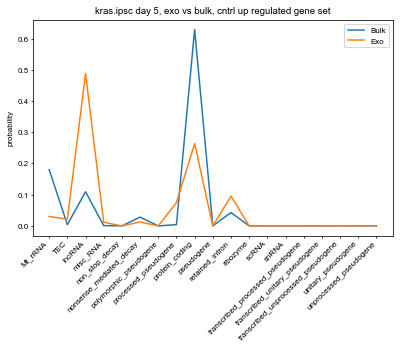

In [42]:
# create panel
figureWidthInInches = 5
figureHeightInInches = 3
fig = plt.figure(figsize=(figureWidthInInches,figureHeightInInches))
panel = mplu.createPanelSameSizeAsFig(fig)

# select data to plot
DF = bioTypeProbDF.loc[:, upDataSets]
legendLabels = [s[len("up"):] for s in upDataSets]
title = "kras.ipsc day 5, exo vs bulk, cntrl up regulated gene set"
PlotProbMass(panel, DF, legendLabels, title)
#panel.save()

In [25]:
# aedwip
# is down regulated useful? can we use this to prove exosome payload is not just a random sample

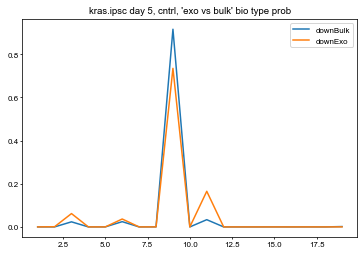

In [26]:
nRows, nCols = bioTypeProbDF.shape
x = np.arange( 1, nRows + 1, 1)

plt.plot(x, bioTypeProbDF.loc[:, downDataSets], label=downDataSets )
plt.legend(downDataSets)
plt.title( "kras.ipsc day 5, cntrl, 'exo vs bulk' bio type prob")
    
plt.show()

## CDS cumlative distribution  Function

In [27]:
bioTypeCDF_DF = np.cumsum(bioTypeProbDF)
bioTypeCDF_DF.tail()

,upBulk,upExo,downBulk,downExo
BioType,,,,
transcribed_processed_pseudogene,0.999346,0.998745,0.998218,0.999665
transcribed_unitary_pseudogene,0.999383,0.998813,0.998222,0.999672
transcribed_unprocessed_pseudogene,0.999929,0.999115,0.998322,0.999760
unitary_pseudogene,0.999934,0.999167,0.998322,0.999763
unprocessed_pseudogene,1.000000,1.000000,1.000000,1.000000


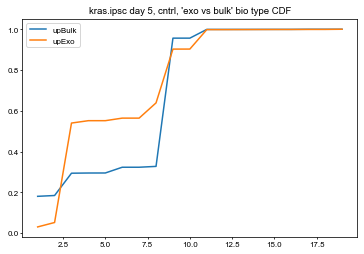

In [28]:
nRows, nCols = bioTypeCDF_DF.shape
x = np.arange( 1, nRows + 1, 1)

plt.plot(x, bioTypeCDF_DF.loc[:, upDataSets], label=upDataSets )
plt.legend(upDataSets)
plt.title( "kras.ipsc day 5, cntrl, 'exo vs bulk' bio type CDF")
    
plt.show()

In [29]:
diffSeries = bioTypeCDF_DF.loc[:,"upBulk"] - bioTypeCDF_DF.loc[:,"upExo"] 
selectRows = diffSeries.abs() > 0.01
DF = bioTypeCDF_DF.loc[selectRows, upDataSets]
DF["bulk - exo"] = bioTypeCDF_DF.loc[:,"upBulk"] - bioTypeCDF_DF.loc[:,"upExo"]
DF

,upBulk,upExo,bulk - exo
BioType,,,
Mt_rRNA,0.180332,0.030261,0.150071
TEC,0.184361,0.051879,0.132481
lncRNA,0.293754,0.539771,-0.246017
misc_RNA,0.294689,0.551437,-0.256748
non_stop_decay,0.294838,0.551439,-0.256601
nonsense_mediated_decay,0.323012,0.563947,-0.240935
polymorphic_pseudogene,0.323021,0.563951,-0.240930
processed_pseudogene,0.327185,0.638697,-0.311511
protein_coding,0.956328,0.902567,0.053760


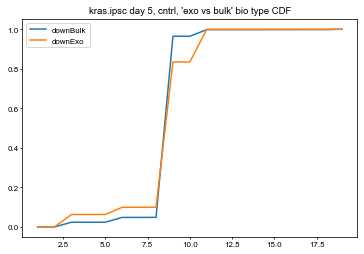

In [30]:
plt.plot(x, bioTypeCDF_DF.loc[:, downDataSets], label=downDataSets )
plt.legend(downDataSets)
plt.title( "kras.ipsc day 5, cntrl, 'exo vs bulk' bio type CDF")

plt.show()

In [31]:
diffSeries = bioTypeCDF_DF.loc[:,"downBulk"] - bioTypeCDF_DF.loc[:,"downExo"] 
selectRows = diffSeries.abs() > 0.01
DF = bioTypeCDF_DF.loc[selectRows, downDataSets]
DF["bulk - exo"] = bioTypeCDF_DF.loc[:,"downBulk"] - bioTypeCDF_DF.loc[:,"downExo"]
DF

,downBulk,downExo,bulk - exo
BioType,,,
lncRNA,0.023593,0.062690,-0.039097
misc_RNA,0.023595,0.062735,-0.039141
non_stop_decay,0.023694,0.062801,-0.039107
nonsense_mediated_decay,0.048071,0.099459,-0.051387
polymorphic_pseudogene,0.048071,0.099462,-0.051391
processed_pseudogene,0.048333,0.099638,-0.051305
protein_coding,0.964544,0.834564,0.129980
pseudogene,0.964544,0.834567,0.129977


## Kolmogorov-Smirnov test
Compare probability distributions

In [32]:
# The distribution is assumed to be continuous.
# If the KS statistic is small or the p-value is high, then we cannot reject the 
# hypothesis that the distributions of the two samples are the same.
# default is 2 sided

# KS is crude. If says there is a difference there probably is else test probably
# just to weak to determine if diff or not

# bug, do not use CDF data
#aedwip ksstat, pvalue = ks_2samp(bioTypeCDF_DF.loc[:, "upBulk"], bioTypeCDF_DF.loc[:, "upExo"])
# up exo vs bulk: ks stat:0.2791 p-value:0.0699

ksstat, pvalue = ks_2samp(bioTypeCountDF.loc[:, "upBulk"], bioTypeCountDF.loc[:, "upExo"])
print("up exo vs bulk: ks stat:{:2.4f} p-value:{:2.4f}".format(ksstat, pvalue))

up exo vs bulk: ks stat:0.2632 p-value:0.5379


In [33]:
ksstat, pvalue = ks_2samp(bioTypeCountDF.loc[:, "downBulk"], bioTypeCountDF.loc[:, "downExo"])
#bug do not use CDF down exo vs bulk: ks stat:0.3023 p-value:0.0387
print("down exo vs bulk: ks stat:{:2.4f} p-value:{:2.4f}".format(ksstat, pvalue))

down exo vs bulk: ks stat:0.3158 p-value:0.3057


In [34]:
bioTypeCountDF.head()

,upBulk,upExo,downBulk,downExo
BioType,,,,
Mt_rRNA,623810.878,114022.780,0.000,0.000
TEC,13933.666,81456.603,1545.629,248.502
lncRNA,378417.392,1838377.070,1082162.737,17749.088
misc_RNA,3230.916,43955.708,63.000,12.000
non_stop_decay,514.723,5.000,4582.477,17.994


Use permutation test to calculate k-s test p-value

In [35]:
numItterations = 10000
ksSimulator = MonteCarlo( numItterations, 
                         kolmogorovSmirnovStat, 
                         shuffleFunc=shuffleParallelList )

bulkUpSeries = bioTypeCountDF.loc[:, "upBulk"] 
exoUpSeries  = bioTypeCountDF.loc[:, "upExo"]
pvalue = ksSimulator.permutationTest(bulkUpSeries, exoUpSeries)
print("  up exo vs bulk: Kolmogorov-Smirnov test p-value:{:2.4f}".format(pvalue))

bulkDownSeries = bioTypeCountDF.loc[:, "downBulk"] 
exoDownSeries  = bioTypeCountDF.loc[:, "downExo"]
pvalue = ksSimulator.permutationTest(bulkDownSeries, exoDownSeries)
print("down exo vs bulk: Kolmogorov-Smirnov test p-value:{:2.4f}".format(pvalue))

  up exo vs bulk: Kolmogorov-Smirnov test p-value:0.1562
down exo vs bulk: Kolmogorov-Smirnov test p-value:0.0535


##  Cross Entropy
Measures "how close to probability distributions are". It is not a distance measurement. I.E. it is not symetric. 

let p = true probablity distribution

let q = predicted probablity distribution

If 
    two distributions are the same the cross entropy equals the entropy
else
    "cross entroy" will be greater than the entropy by some number of bits

"relative entropy" is the amount the cross entropy exceeds the entropy. This is also known as the "kl divergance" or the "Kullback–Leibler divergence"

"cross entropy" = entropy + "Kullback–Leibler divergence"


[A Short Introduction to Entropy, Cross-Entropy and KL-Divergence](https://www.youtube.com/watch?v=ErfnhcEV1O8)

In [36]:
numItterations = 10000
klSimulator = MonteCarlo( numItterations, 
                         kullbackLeiblerStat, 
                         shuffleFunc=shuffleParallelList )

bulkUpSeries = bioTypeProbDF.loc[:, "upBulk"] 
exoUpSeries  = bioTypeProbDF.loc[:, "upExo"] 
KLStat = entropy(bulkUpSeries, exoUpSeries, base=2)
pvalue = klSimulator.permutationTest(bulkUpSeries, exoUpSeries)
print("  up exo vs bulk: Kullback–Leibler divergence:{:2.4f} p-value:{:2.4f}"
      .format(KLStat, pvalue))

bulkDownSeries = bioTypeProbDF.loc[:, "downBulk"] 
exoDownSeries  = bioTypeProbDF.loc[:, "downExo"]
KLStat = entropy(bulkUpSeries, exoUpSeries, base=2)
pvalue = ksSimulator.permutationTest(bulkDownSeries, bulkDownSeries)
print("down exo vs bulk: Kullback–Leibler divergence:{:2.4f} p-value:{:2.4f}"
      .format(KLStat, pvalue))

  up exo vs bulk: Kullback–Leibler divergence:0.9709 p-value:0.7846
down exo vs bulk: Kullback–Leibler divergence:0.9709 p-value:1.0000


In [37]:
#bulkDownSeries

In [38]:
#exoDownSeries

In [39]:
(bulkDownSeries - exoDownSeries).abs().sum()

0.365991342107163

In [40]:
aedwip save

SyntaxError: invalid syntax (<ipython-input-40-b3ac89463ee1>, line 1)

## Explore the distribution of by by type

In [ ]:
def selectBioTypeDistribution(df, bioType) :
    '''
    returns a pandas series of NumReads + psudo count
    
    arguments:
        df: data frame with a column named 'BioType'
        bioType: a string. examples "lncRNA" or "miRNA"
    '''
    # create a logical for each transcript
    isBT = df.loc[:,"BioType"] == bioType

    # multiplying by isBT ensures each transcript will have a count
    psudoCount = 1
    retSeries = df.loc[:, "NumReads"] * isBT + psudoCount
    return retSeries
  
bt = "lncRNA"
aedwipDF[bt] = selectBioTypeDistribution(aedwipDF, bt)
aedwipDF